# Non-linear TDC-GTD

#### Guillaume Berger

I intended to reproduce the results of "Convergent Temporal-Difference Learning with Arbitrary Smooth Function Approximation" by H. R. Maei et al. (2011). Unfortunately, I never managed to reproduce the results showed in Figure 2. I tried using the exact same parameters as the ones mentioned in the article, I tried other values, but at the end, I've never managed to obtain a scenario where : TD(0) diverges, TDC/GTD converges. 

I'll try to investigate what's going wrong. I'll also try to take a look if someone else from the class worked on this, and manage to reproduce Figure 2.

### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pickle
from IPython.display import Image

## The "spiral" counter example of Tsitsikilis & Van Roy (1997)

### The MDP

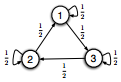

In [2]:
Image("imgs/spiral1.png", height=200, width=200)

All rewards are 0. So the true value function is (0, 0, 0)

In [3]:
class SpiralCounterExample():
    def __init__(self, seed=None):
        self.state = 0
        if seed is not None:
            np.random.seed(seed)
        
    def iterate(self):
        if np.random.rand()>0.5:
            self.state = (self.state - 1)%3
        return 0.

In [4]:
LAMBDA = 0.866
EPSILON = 0.05
A = np.array([100., -70., -30.])/200.
B = np.array([23.094, -98.15, 75.056])/200.

def spiral_approximator(s, theta, l=LAMBDA, epsilon=EPSILON, a=A, b=B):
    return (a[s]*np.cos(l*theta)-b[s]*np.sin(l*theta))*np.exp(epsilon*theta)

def grad_spiral_approximator(s, theta, l=LAMBDA, epsilon=EPSILON, a=A, b=B):
    grad = (-l*a[s]*np.sin(l*theta)-l*b[s]*np.cos(l*theta))*np.exp(epsilon*theta) 
    grad += epsilon*spiral_approximator(s, theta, l, epsilon, a, b)
    return grad

def grad_grad_spiral_approximator(s, theta, l=LAMBDA, epsilon=EPSILON, a=A, b=B):
    
    grad = (-l*a[s]*np.cos(l*theta)+l*b[s]*np.sin(l*theta))*np.exp(epsilon*theta) 
    grad += epsilon*(-l*a[s]*np.sin(l*theta)-l*b[s]*np.cos(l*theta))*np.exp(epsilon*theta)
    grad += epsilon*grad_spiral_approximator(s, theta, l, epsilon, a, b)
    return grad

In [5]:
# This is the 3D plotting toolkit
from mpl_toolkits.mplot3d import Axes3D

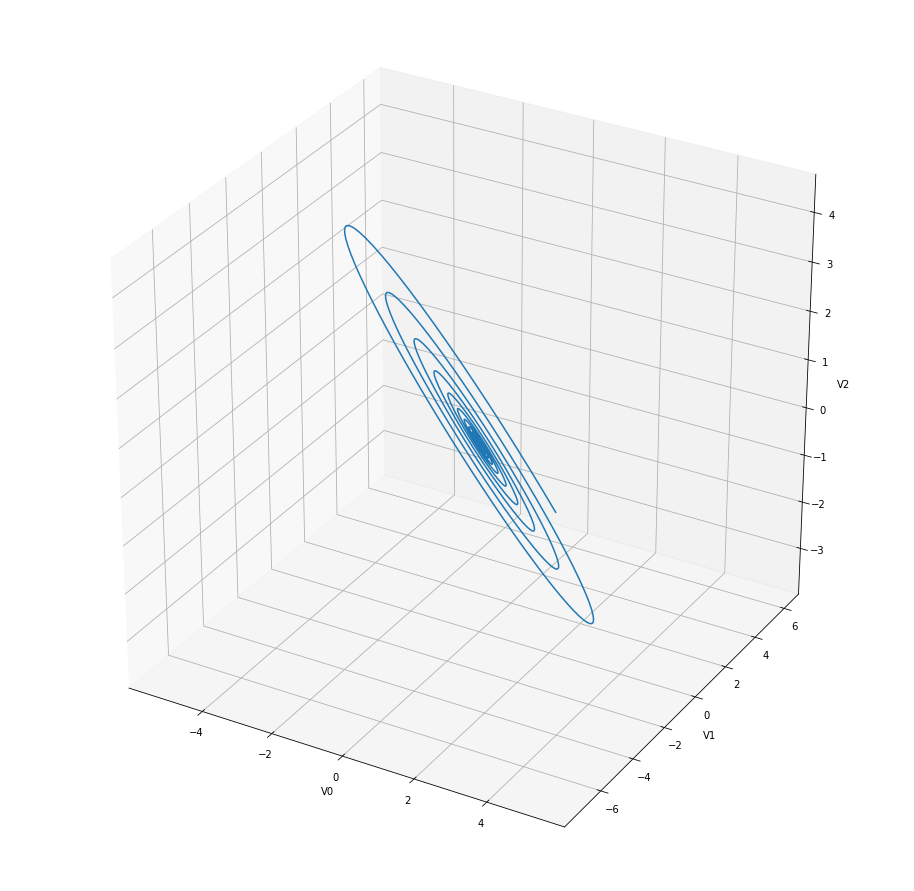

In [6]:
thetas = np.arange(-50., 50., 0.1)
V0 = spiral_approximator(0, thetas)
V1 = spiral_approximator(1, thetas)
V2 = spiral_approximator(2, thetas)

plt.figure(figsize=(16,16))
ax = plt.axes(projection='3d')
ax.plot(V0, V1, V2) #, c=thetas+50.)
ax.set_xlabel("V0")
ax.set_ylabel("V1")
ax.set_zlabel("V2")
plt.show()

In [7]:
spiral_example = SpiralCounterExample(seed=123)

In [8]:
P = np.array([[0.5, 0., 0.5],[0.5, 0.5, 0.],[0., 0.5, 0.5]])
P

array([[ 0.5,  0. ,  0.5],
       [ 0.5,  0.5,  0. ],
       [ 0. ,  0.5,  0.5]])

In [9]:
def policy_prediction(spiral_example, gamma, alpha, max_iterations, P, mode="TD(0)", beta=None):
    theta = 0.
    w = 0.
    history = []
    # Loop until it terminates
    count = 0
    while count < max_iterations:
        # Observe S, R, S'
        S = spiral_example.state
        R = spiral_example.iterate()
        S_prime = spiral_example.state
        
        # Some useful quantities
        V = spiral_approximator(S, theta)
        V_prime = spiral_approximator(S_prime, theta)
        TD_error = (R + gamma*V_prime - V)
        grad = grad_spiral_approximator(S, theta)
        grad_prime = grad_spiral_approximator(S_prime, theta)
        grad_second = grad_grad_spiral_approximator(S, theta)
        
        # Theta Update
        if mode == "TD(0)":
            theta += alpha*TD_error*grad 

        elif mode == "GTD2":
            h = (TD_error-grad*w)*grad_second*w 
            theta += alpha*((grad - gamma*grad_prime)*(grad*w) - h) 
            w += beta*(TD_error - grad*w)*grad 


        elif mode == "TDC":
            h = (TD_error-grad*w)*grad_second*w   
            theta += alpha*(TD_error*grad - (gamma*grad_prime*grad*w) - h) 
            w += beta*(TD_error - grad*w)*grad 

        # Increment and compute current loss
        count += 1
        
        V_theta = np.array([spiral_approximator(s, theta) for s in range(3)])
        Phi_theta = np.array([grad_spiral_approximator(s, theta) for s in range(3)])
        Pi_theta = np.dot(Phi_theta[:,None], Phi_theta[None,:])/np.sum(Phi_theta**2)
        J = np.mean((np.dot(Pi_theta, np.dot(P, V_theta) - V_theta))**2)
        
        history.append(np.sqrt(J))
        
    return theta, history

In [10]:
spiral_example = SpiralCounterExample(seed=123)
theta_td0, h_td0 = policy_prediction(spiral_example, gamma=0.9, alpha=0.05, max_iterations=10000, P=P)

In [11]:
print 'Theta:   \t', theta_td0
print 'V_theta:\t', [spiral_approximator(s, theta_td0) for s in range(3)]

Theta:   	1.59451572775
V_theta:	[-0.020566440047234166, 0.45035237988610261, -0.42978593983886842]


In [12]:
spiral_example = SpiralCounterExample(seed=123)
theta_gtd2, h_gtd2 = policy_prediction(spiral_example, gamma=0.9, alpha=0.05, 
                             max_iterations=10000, P=P, mode="GTD2", 
                             beta=0.01)

In [13]:
print 'Theta:   \t', theta_gtd2
print 'V_theta:\t', [spiral_approximator(s, theta_gtd2) for s in range(3)]

Theta:   	-1.92392656339
V_theta:	[0.061178388261558983, -0.41345992441204493, 0.35228153615048596]


In [14]:
spiral_example = SpiralCounterExample(seed=123)
theta_tdc, h_tdc = policy_prediction(spiral_example, gamma=0.9, alpha=0.05, 
                             max_iterations=10000, P=P, mode="TDC", 
                             beta=0.01)

In [15]:
print 'Theta:   \t', theta_tdc
print 'V_theta:\t', [spiral_approximator(s, theta_tdc) for s in range(3)]

Theta:   	1.53462375631
V_theta:	[0.0082285203841955378, 0.42397542200767818, -0.43220394239187371]


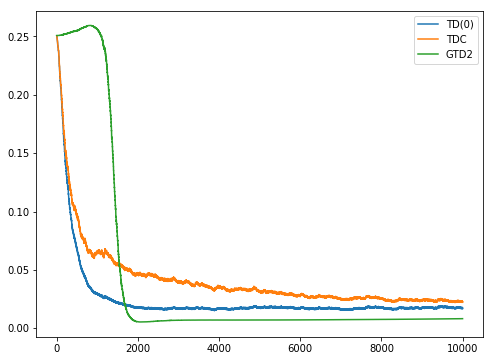

In [21]:
plt.figure(figsize=(8,6))
plt.plot(h_td0, label="TD(0)")
plt.plot(h_tdc, label="TDC")
plt.plot(h_gtd2, label="GTD2")
plt.legend()
plt.show()